In [16]:
#%%
import json
import sys
from argparse import Namespace
from pathlib import Path
from time import time

import numpy as np
import torch
import resnet3d

# sys.path.append("resnet3d/")
import torchvision
from IPython.display import HTML
from resnet3d.main import generate_model, get_inference_utils, resume_model
from resnet3d.model import generate_model, make_data_parallel
from torch.backends import cudnn
from torchvision.transforms import transforms
from torchvision.transforms.transforms import Normalize, ToPILImage

sys.path.append("src/")

from utils.dataset_utils import load_jpg_mydata
from utils.sensitivity_analysis import OcclusionSensitivityMap3D as OSM
from utils.visualization import visualize

In [17]:
#%%
opt_path = "resnet3d/results/right-handed/opts.json"
# opt_path = "data/r3d_models/finetuning/right-handed-full/opts.json"
with open(opt_path, "r") as f:
    model_opt = json.load(f)
model_opt = Namespace(**model_opt)

model_opt.device = torch.device("cpu" if model_opt.no_cuda else "cuda")
if not model_opt.no_cuda:
    cudnn.benchmark = True
if model_opt.accimage:
    torchvision.set_image_backend("accimage")

model_opt.ngpus_per_node = torch.cuda.device_count()

model = generate_model(model_opt)
model = resume_model(model_opt.resume_path, model_opt.arch, model)
model = make_data_parallel(model, model_opt.distributed, model_opt.device)
model.eval()

model_opt.inference_batch_size = 1
for attribute in dir(model_opt):
    if "path" in str(attribute) and getattr(model_opt, str(attribute)) != None:
        setattr(model_opt, str(attribute), Path(getattr(model_opt, str(attribute))))
inference_loader, inference_class_names = get_inference_utils(model_opt)
print(inference_class_names)
print(f"Dataset size: {len(inference_loader.dataset)}")
class_labels_map = {v.lower(): k for k, v in inference_class_names.items()}



/home/kazuoki/iaosa/resnet3d/models/densenet.py:132: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


loading checkpoint resnet3d/results/right-handed/right-handed-densenet_save_200.pth model
model: DenseNet(
  (features): Sequential(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _D

In [18]:
#%%
inputs, targets = iter(inference_loader).__next__()
video_size = inputs[[0]].shape
transform = inference_loader.dataset.spatial_transform

_transforms = transform.transforms
idx = [type(i) for i in _transforms].index(resnet3d.spatial_transforms.Normalize)
normalize = _transforms[idx]
mean = torch.tensor(normalize.mean)
std = torch.tensor(normalize.std)

unnormalize = transforms.Compose(
    [
        Normalize((-mean / std).tolist(), (1 / std).tolist()),
        ToPILImage(),
    ]
)



In [19]:
#%%
spatial_crop_size = 16
spatial_stride = 8
temporal_stride = 2

aosa_single = OSM(
    net=model,
    video_size=video_size,
    device=model_opt.device,
    spatial_crop_size=spatial_crop_size,
    spatial_stride=spatial_stride,
    temporal_stride=temporal_stride,
    transform=transform,
    batchsize=400,
    N_stack_mask=1,
)

aosa = OSM(
    net=model,
    video_size=video_size,
    device=model_opt.device,
    spatial_crop_size=spatial_crop_size,
    spatial_stride=spatial_stride,
    temporal_stride=temporal_stride,
    transform=transform,
    batchsize=400,
    N_stack_mask=8,
)




In [39]:
#%%
l = 1
n = 0

video = load_jpg_mydata("R4105", l, n, inference_class_names, transform).transpose(0, 1)
target = l
with torch.inference_mode():
    pred = model(video.unsqueeze(0)).cpu().numpy().argmax()
video_orgimg = []

for i in range(video_size[2]):
    img = video.squeeze().transpose(0, 1)[i]
    video_orgimg.append(np.array(unnormalize(img)))
video_orgimg = np.array(video_orgimg)
print(f'img size: {img.shape}')

start = time()
aosa_single_map = aosa_single.run(video, target)
print(time() - start)

start = time()
aosa_map = aosa.run(video, target)
print(time() - start)

print("heatmap size: ", aosa_single_map.shape)

title = "{} (pred: {})".format(inference_class_names[l], inference_class_names[pred])

s = visualize(
    "AOSA",
    [aosa_single_map, aosa_map],
    video_orgimg,
    title=title,
)

HTML(s)


img size: torch.Size([3, 112, 112])
1.6511902809143066
2.0974538326263428
heatmap size:  (16, 112, 112)


In [21]:

# with open("myaosa.html", "w") as f:
#     f.write(s)

In [22]:
import matplotlib.pyplot as plt
import os

img_with_mask = aosa_single.apply_masks_to_video(video, target).numpy() # 動画に168通りのマスクの付け方をしている．(AOSA済み)
print(img_with_mask.shape)
print(type(img_with_mask))

output_dir = './masks'
os.makedirs(output_dir, exist_ok=True)

# # Process each frame
# for i in range(0, img_with_mask.shape[0], 50):
#     fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4x4のサブプロットで16枚の画像を表示
#     fig.suptitle(f'Set {i + 1}', fontsize=16)
    
#     # 16フレームのデータを表示するためのループ
#     for j in range(16):
#         ax = axs[j // 4, j % 4]  # 4x4グリッドの位置を計算
#         frame = img_with_mask[i, :, j, :, :].transpose(1, 2, 0)  # (3, 112, 112) -> (112, 112, 3) に次元を変換
#         frame = (frame - frame.min()) / (frame.max() - frame.min())  # 値を0から1の範囲に正規化
#         ax.imshow(frame)
#         ax.axis('off')  # 軸を非表示にする
#     fig.savefig(fname=f"org_set{i}.jpg")
#     plt.show()

(196, 3, 16, 112, 112)
<class 'numpy.ndarray'>


In [23]:
img_with_mask = aosa_single.apply_inverse_masks_to_video(video, target).numpy() # 動画に168通りのマスクの付け方をしている．(AOSA済み)
print(img_with_mask.shape)
print(type(img_with_mask))

output_dir = './masks'
os.makedirs(output_dir, exist_ok=True)

# # Process each frame
# for i in range(0, img_with_mask.shape[0], 50):
#     fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4x4のサブプロットで16枚の画像を表示
#     fig.suptitle(f'Set {i + 1}', fontsize=16)
    
#     # 16フレームのデータを表示するためのループ
#     for j in range(16):
#         ax = axs[j // 4, j % 4]  # 4x4グリッドの位置を計算
#         frame = img_with_mask[i, :, j, :, :].transpose(1, 2, 0)  # (3, 112, 112) -> (112, 112, 3) に次元を変換
#         frame = (frame - frame.min()) / (frame.max() - frame.min())  # 値を0から1の範囲に正規化
#         ax.imshow(frame)
#         ax.axis('off')  # 軸を非表示にする
#         ax.set_title(f'Frame {j + 1}')
#     fig.savefig(fname=f"set{i}.jpg")
#     plt.show()

(196, 3, 16, 112, 112)
<class 'numpy.ndarray'>


pred_tensor shape: torch.Size([1, 2])
torch.Size([3, 16, 112, 112])
1.8404252529144287
2.1974732875823975


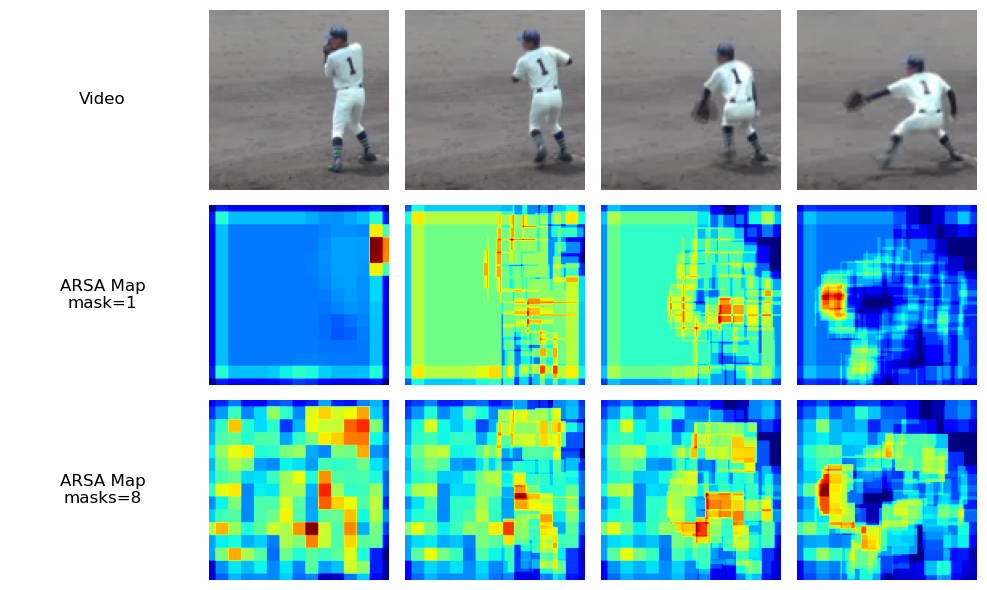

: 

In [ ]:
#%%
# l = 21
# g = 1  # > 0
# c = 1  # > 0
# n = 1
l = 1
n = 0

video = load_jpg_mydata("R4105", l, n, inference_class_names, transform).transpose(0, 1)
# video.shpae = torch.Size([3, 16, 112, 112])
target = l
with torch.inference_mode():
    pred_tensor = model(video.unsqueeze(0))
    # ResNet3Dによる予測
    # ucf-101 のそれぞれのクラスに対する予測値が得られる shape = torch.Size([1, 101])
    print(f"pred_tensor shape: {pred_tensor.shape}") 
    pred = pred_tensor.cpu().numpy().argmax()
    # 予測スコアの最も高いクラスのインデックスを取得できる
video_orgimg = []

for i in range(video_size[2]): # videp_size = torch.Size([1, 3, 16, 112, 112])
    img = video.squeeze().transpose(0, 1)[i]
    # video.squeeze() -> torch.Size([3, 16, 112, 112])
    # video.squeeze().transpose(0, 1) -> torch.Size([16, 3, 112, 112])
    # img -> torch.Size([3, 112, 112])
    video_orgimg.append(np.array(unnormalize(img)))
    # unnormalize は　[0, 1] で正規化された値を [0, 255] の画像用の値に戻す操作
    # unnormalize(img) -> PIL画像 (112, 112), mode -> RGB
    # np.array(unnormalize(img)) -> (112, 112, 3)
video_orgimg = np.array(video_orgimg) # video_orgimg -> np.array([16, 112, 112, 3])

start = time()
print(video.shape)
aosa_single_map = aosa_single.inverse_run(video, target) # map shape: torch.Size([16, 112, 112])
print(time() - start)

start = time()
aosa_map = aosa.inverse_run(video, target)
print(time() - start)

title = "{} (pred: {})".format(inference_class_names[l], inference_class_names[pred])

s = visualize(
    "ARSA",
    [aosa_single_map, aosa_map],
    video_orgimg,
    w=0.7,
    title=title,
)

HTML(s)

In [25]:
# with open("myaosa.html", "w") as f:
#     f.write(s)

In [26]:
from evaluation.evaluation import CausalMetric, auc, gkern
import torch.nn as nn

In [27]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

def blur_video(x):
    out = x.copy()
    for i in range(16):
        out[0, i] = nn.functional.conv2d(x[0, i], kern, padding=klen//2)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

In [28]:
insertion = CausalMetric(model, 'ins', 112, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 112, substrate_fn=torch.zeros_like)
# torch.zeros_like は，ある tensor の値をすべて0にしたいときに使う．

c: 1
n_steps: 112
this is 112 steps


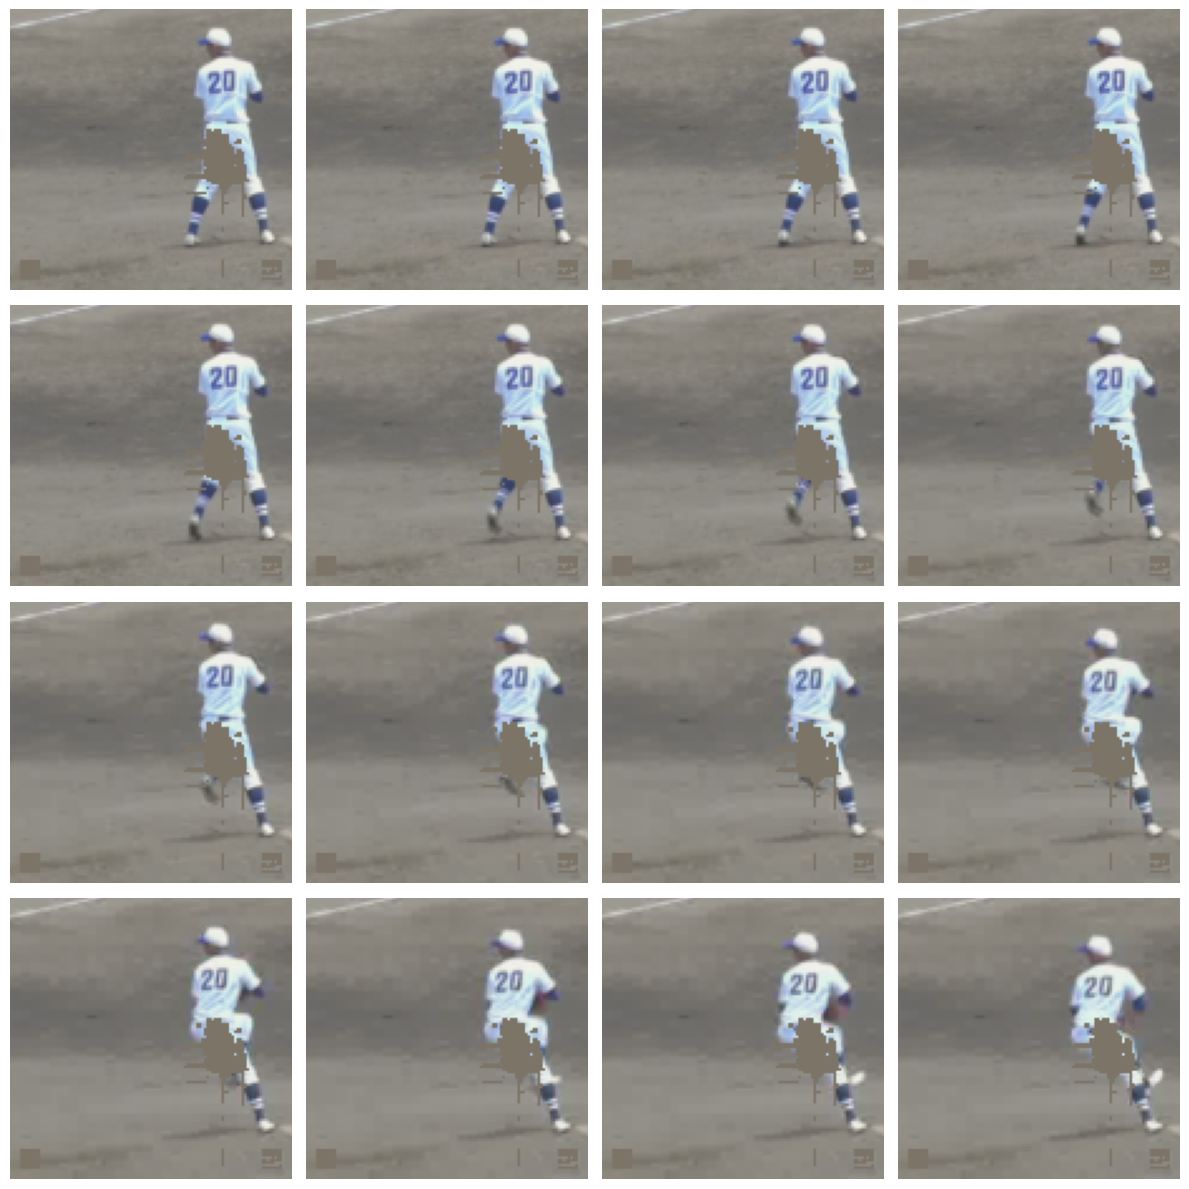

AUC: 0.5044590173555272
this is 112 steps


AUC: 0.9379551122155118


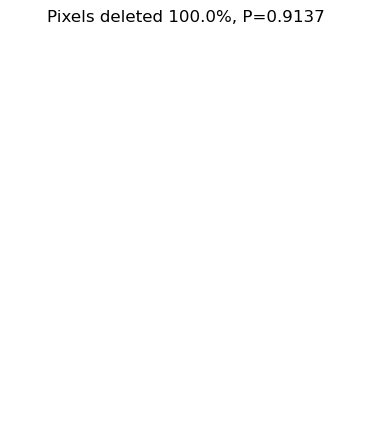

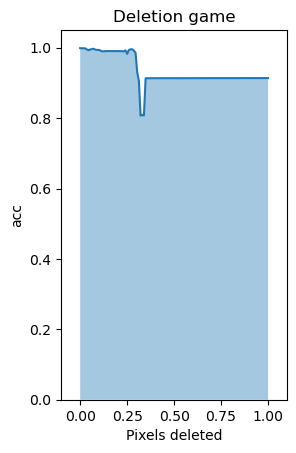

In [29]:
h = deletion.single_run(pred, video, aosa_single_map, verbose=1)

c: 1
n_steps: 112
this is 112 steps


AUC: 0.9843506850302219
this is 112 steps


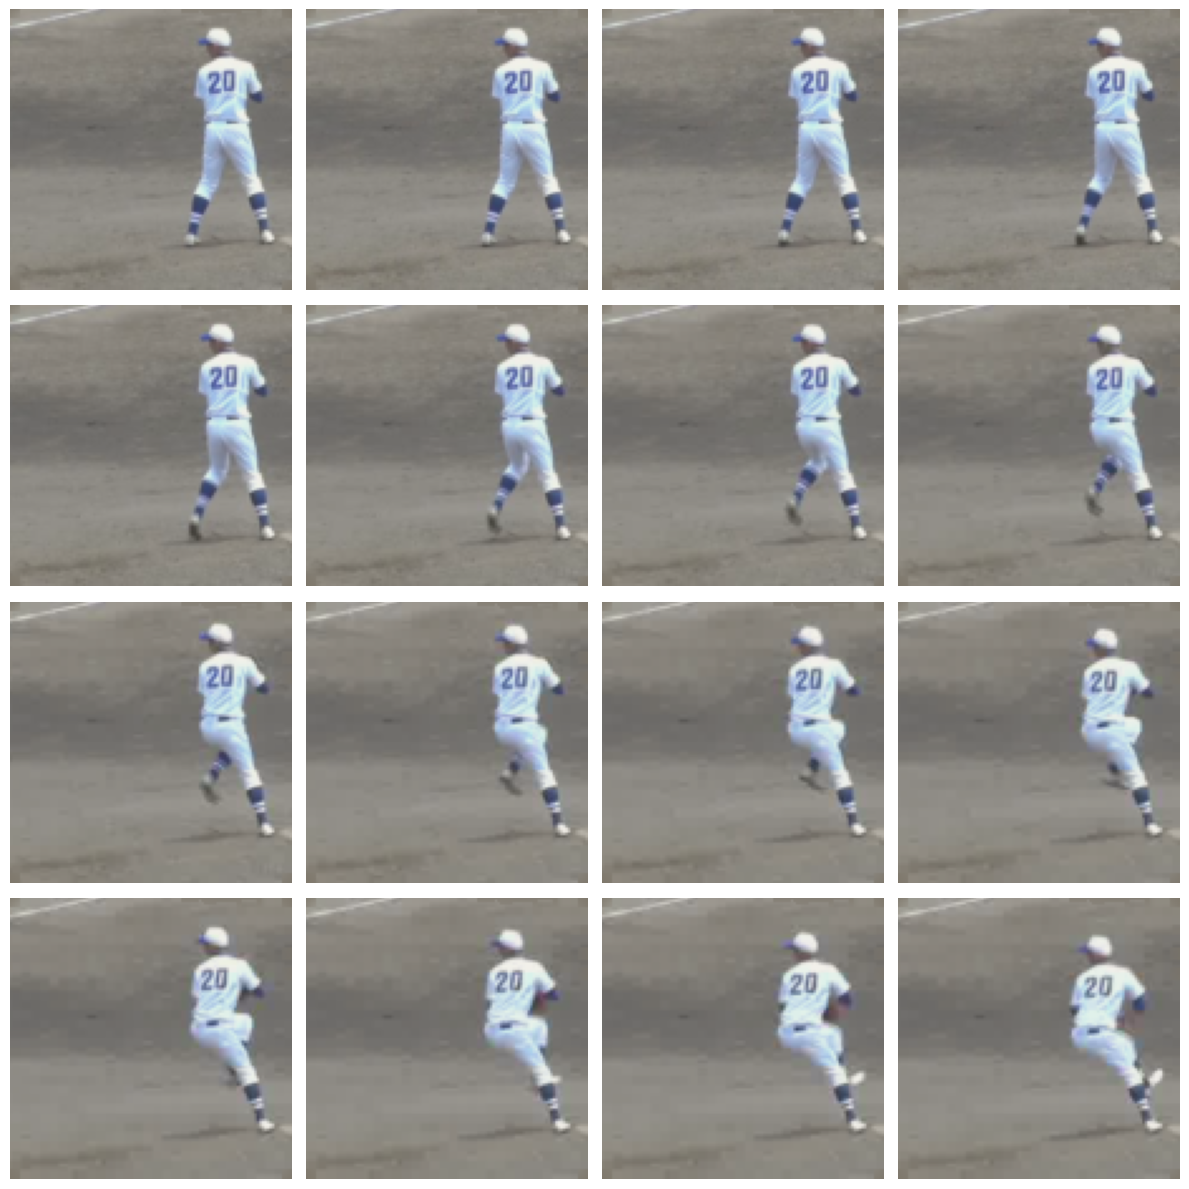

AUC: 0.9646077480699334


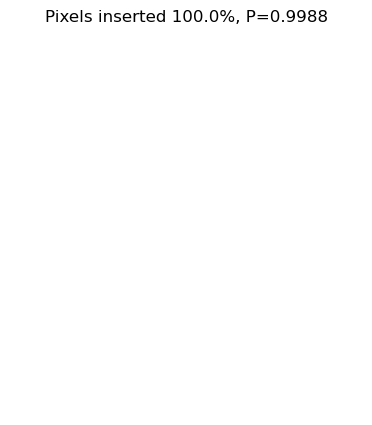

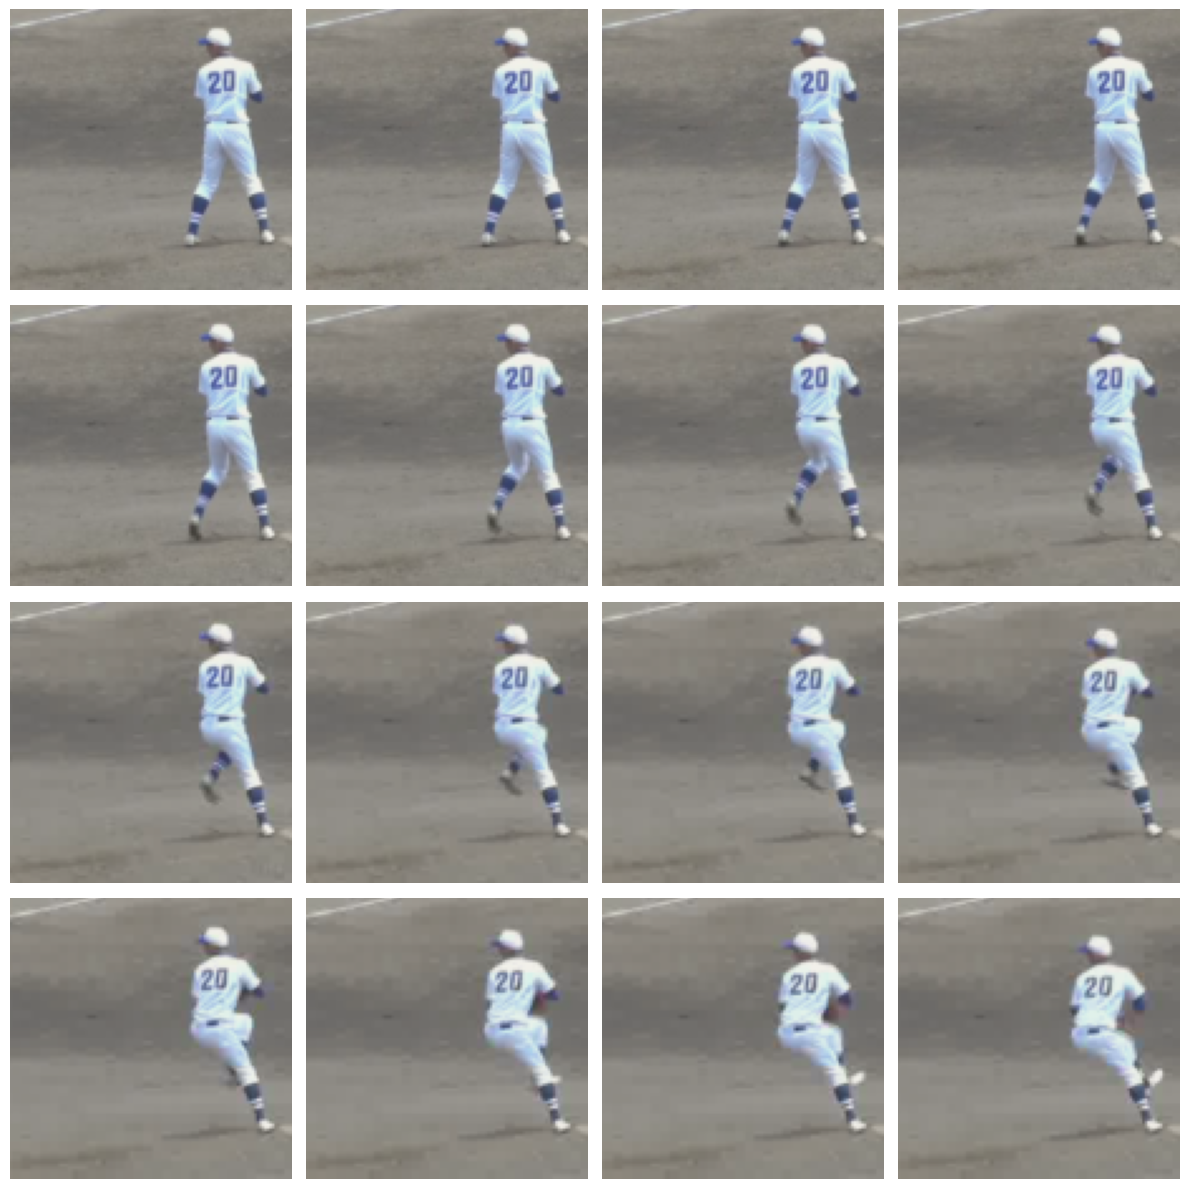

In [30]:
h  = insertion.single_run(pred, video, aosa_single_map, verbose=1)